In [4]:
# adapted from https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
from PIL import Image
import openslide
import sys
import os
import logging
import numpy as np
from tqdm import trange
import concurrent.futures

In [5]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

In [44]:
np.sum(skimage.io.imread(images[3])[:, :, :2])

223745035

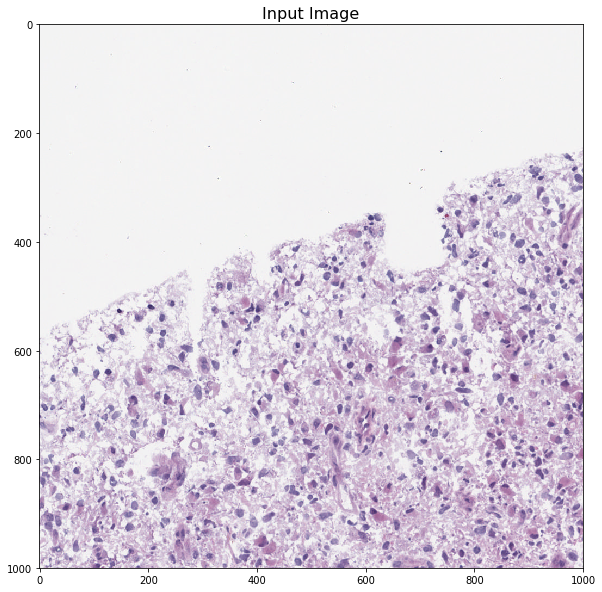

In [48]:
input_dir = '../tcga/dense/gbm/'
images = [input_dir + imname for imname in os.listdir(input_dir)]

input_image_file = (images[30])  # Easy1.png

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

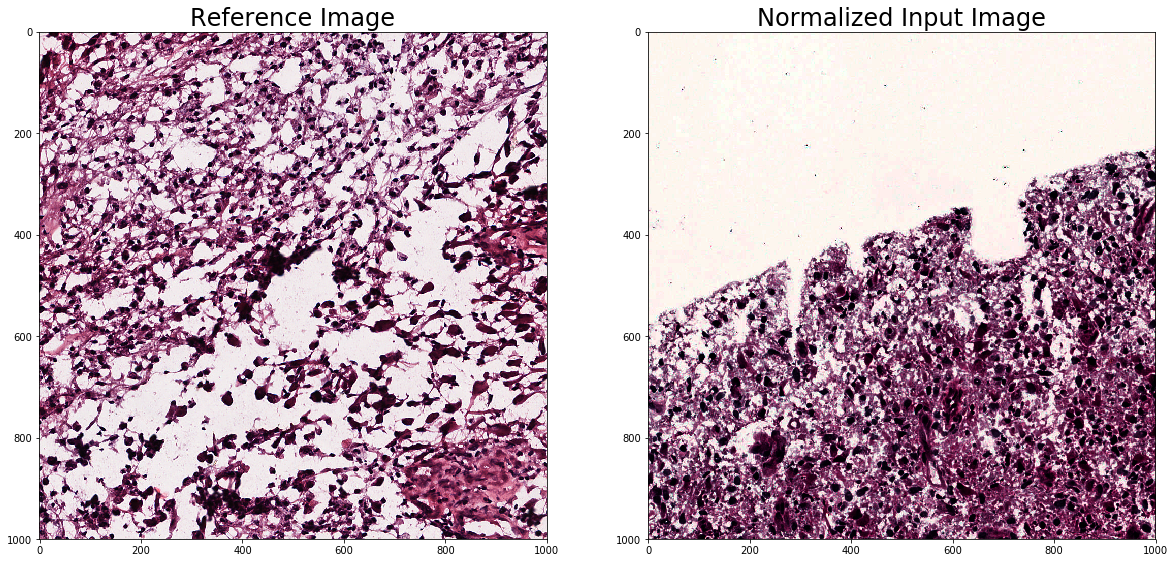

In [49]:

# Load reference image for normalization
ref_image_file = (images[20])  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)

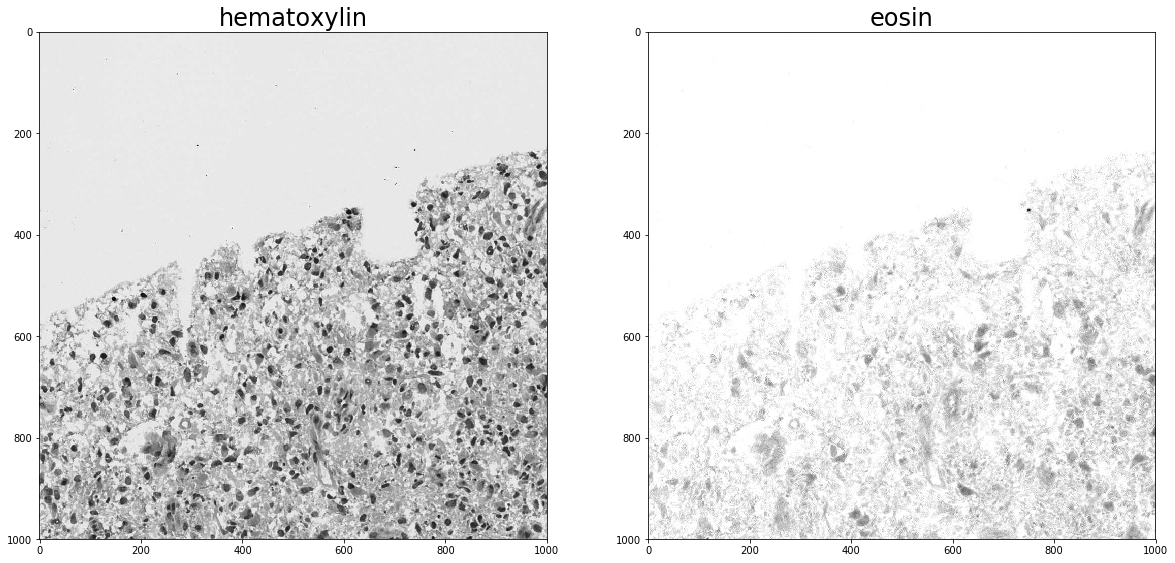

In [50]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_input, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

Number of nuclei =  209


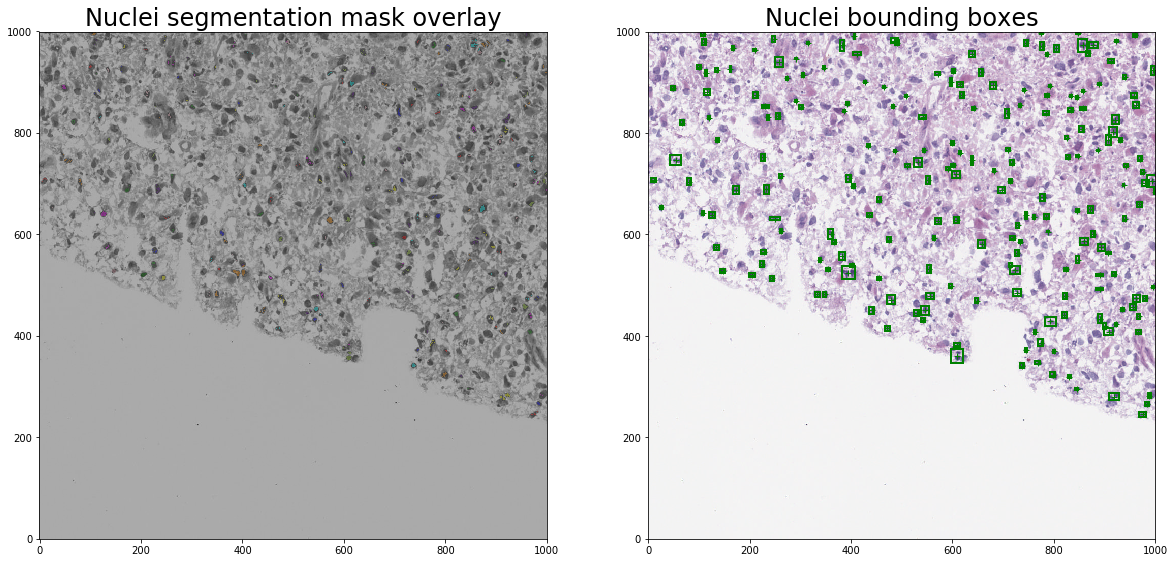

In [100]:
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 5
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 5

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
#objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print 'Number of nuclei = ', len(objProps)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

In [278]:
a = htk.features.compute_morphometry_features(im_nuclei_seg_mask)

In [298]:
d = a.mean().to_dict()
d['Case'] = pat_name
pd.Series(d)

Case                         TCGA-14-0865
Shape.Circularity                 2.02834
Shape.Eccentricity               0.829726
Shape.EquivalentDiameter          5.04633
Shape.Extent                     0.403355
Shape.MinorMajorAxisRatio        0.499084
Shape.Solidity                   0.596338
Size.Area                         23.2488
Size.MajorAxisLength              11.5092
Size.MinorAxisLength              5.26614
Size.Perimeter                    16.2321
dtype: object

In [180]:
tumor_type = 'gbm'
filename = images[0]
xlsx = pd.read_excel('../tcga/TableS1.PatientData.20151020.v3.xlsx', skiprows=1)
xlsx['Grade'] = xlsx['Grade'].str.slice(1)
xlsx['Grade'] = pd.to_numeric(xlsx['Grade'])
xlsx['Gender'] = (xlsx['Gender'] == 'male').astype(np.int64)
xlsx['MGMT promoter status'] = (xlsx['MGMT promoter status'] == 'Methylated').astype(np.int64)
pat_name = filename.split(tumor_type+"/")[1][:len('TCGA-CS-4938')]

#pat_name = 'TCGA-02-0329'
pat_stats = xlsx[xlsx['Case'] == pat_name]

#xlsx['Histology'].unique()
#pat_stats['Grade']
#xlsx.head()

array([u'astrocytoma', u'oligodendroglioma', u'oligoastrocytoma', nan,
       u'glioblastoma'], dtype=object)

In [210]:
b = pat_stats[['Case','Grade', 'Age (years at diagnosis)', \
           'Gender', 'Survival (months)', 'Vital status (1=dead)',\
           'MGMT promoter status']]

In [277]:
pd.DataFrame(pd.concat((a.mean(), b.squeeze()))).T

Size.Area Size.MajorAxisLength Size.MinorAxisLength Size.Perimeter  \
0   23.2488              11.5092              5.26614        16.2321   

  Shape.Circularity Shape.Eccentricity Shape.EquivalentDiameter Shape.Extent  \
0           2.02834           0.829726                  5.04633     0.403355   

  Shape.MinorMajorAxisRatio Shape.Solidity index          Case Grade  \
0                  0.499084       0.596338     0  TCGA-14-0865     4   

  Age (years at diagnosis) Gender Survival (months) Vital status (1=dead)  \
0                       67      1           16.4932                     1   

  MGMT promoter status  
0                    1